In [3]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy.fuzzy_layer import FuzzyLayer


In [4]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 4
fuzzy_dim = 4
beta = 1
gamma = 1 
fuzzy_labels = 10 #10 numbers 
unknown_classes_ratio = 0.0 # unknow samples rate
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [6]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [7]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [8]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [9]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [10]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [11]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [12]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count, fuzzy_dim):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        self.fuzzy_dim = fuzzy_dim
        self.fuzzy = nn.Sequential(
            FuzzyLayer.fromdimentions(fuzzy_dim, labels_count, trainable=True)
        )
        
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [13]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [14]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels, fuzzy_dim=fuzzy_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,694,211


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=8, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [17]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:, 0:10].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [18]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)


Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 20.4674 (Recon: 19.0802, KL: 0.3374 Fuzzy: 1.0498) Grad: 14.2555
Step 100 (N samples: 25,600), Loss: 8.3595 (Recon: 7.0756, KL: 0.5919 Fuzzy: 0.6920) Grad: 9.2806
Step 200 (N samples: 51,200), Loss: 7.8334 (Recon: 6.5840, KL: 0.7118 Fuzzy: 0.5376) Grad: 3.5794


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.2267 (BCE: 6.6065, KLD: 1.0411 Fuzzy: 0.5791 Accuracy 0.6632)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.8647 (Recon: 6.4714, KL: 0.9099 Fuzzy: 0.4833) Grad: 6.8283
Step 400 (N samples: 102,400), Loss: 7.3164 (Recon: 6.0017, KL: 0.8466 Fuzzy: 0.4681) Grad: 7.5161


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6085 (BCE: 6.1008, KLD: 1.1021 Fuzzy: 0.4056 Accuracy 0.8140)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.3896 (Recon: 6.1089, KL: 0.9258 Fuzzy: 0.3549) Grad: 3.6895
Step 600 (N samples: 153,600), Loss: 7.4402 (Recon: 6.1614, KL: 0.9594 Fuzzy: 0.3194) Grad: 3.1515
Step 700 (N samples: 179,200), Loss: 7.3874 (Recon: 6.0784, KL: 1.0178 Fuzzy: 0.2911) Grad: 5.7570


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3493 (BCE: 6.0420, KLD: 1.0317 Fuzzy: 0.2756 Accuracy 0.9214)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.3367 (Recon: 6.0149, KL: 1.0598 Fuzzy: 0.2620) Grad: 3.1903
Step 900 (N samples: 230,400), Loss: 7.2340 (Recon: 5.9168, KL: 1.0356 Fuzzy: 0.2815) Grad: 3.2970


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2837 (BCE: 5.9036, KLD: 1.1363 Fuzzy: 0.2438 Accuracy 0.9396)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.0915 (Recon: 5.7912, KL: 1.0602 Fuzzy: 0.2401) Grad: 2.1552
Step 1,100 (N samples: 281,600), Loss: 7.2915 (Recon: 5.9564, KL: 1.0968 Fuzzy: 0.2383) Grad: 2.6947


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2289 (BCE: 5.9134, KLD: 1.1084 Fuzzy: 0.2071 Accuracy 0.9496)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.3335 (Recon: 6.0426, KL: 1.0724 Fuzzy: 0.2185) Grad: 2.8040
Step 1,300 (N samples: 332,800), Loss: 7.0861 (Recon: 5.8094, KL: 1.0838 Fuzzy: 0.1929) Grad: 1.7678
Step 1,400 (N samples: 358,400), Loss: 7.3054 (Recon: 5.9529, KL: 1.1373 Fuzzy: 0.2152) Grad: 3.3670


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2193 (BCE: 5.8024, KLD: 1.1846 Fuzzy: 0.2323 Accuracy 0.9464)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.2882 (Recon: 5.9637, KL: 1.1395 Fuzzy: 0.1850) Grad: 2.2303
Step 1,600 (N samples: 409,600), Loss: 7.3783 (Recon: 5.9549, KL: 1.2157 Fuzzy: 0.2076) Grad: 4.0036


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1451 (BCE: 5.8283, KLD: 1.1448 Fuzzy: 0.1720 Accuracy 0.9581)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.2785 (Recon: 5.9146, KL: 1.1626 Fuzzy: 0.2012) Grad: 2.9583
Step 1,800 (N samples: 460,800), Loss: 6.9658 (Recon: 5.6734, KL: 1.1270 Fuzzy: 0.1654) Grad: 1.9245


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1660 (BCE: 5.7579, KLD: 1.2305 Fuzzy: 0.1776 Accuracy 0.9618)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.2747 (Recon: 5.9188, KL: 1.1595 Fuzzy: 0.1964) Grad: 2.7754
Step 2,000 (N samples: 512,000), Loss: 7.2035 (Recon: 5.8929, KL: 1.1546 Fuzzy: 0.1560) Grad: 2.3037
Step 2,100 (N samples: 537,600), Loss: 7.1275 (Recon: 5.8459, KL: 1.1163 Fuzzy: 0.1652) Grad: 2.2897


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1306 (BCE: 5.8659, KLD: 1.0952 Fuzzy: 0.1695 Accuracy 0.9636)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.1924 (Recon: 5.9265, KL: 1.1155 Fuzzy: 0.1504) Grad: 3.0639
Step 2,300 (N samples: 588,800), Loss: 7.0677 (Recon: 5.7382, KL: 1.1478 Fuzzy: 0.1817) Grad: 2.1664


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0863 (BCE: 5.7945, KLD: 1.1438 Fuzzy: 0.1480 Accuracy 0.9664)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.0946 (Recon: 5.7730, KL: 1.1992 Fuzzy: 0.1224) Grad: 2.3059
Step 2,500 (N samples: 640,000), Loss: 7.1410 (Recon: 5.8433, KL: 1.1700 Fuzzy: 0.1277) Grad: 2.2480


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0933 (BCE: 5.8299, KLD: 1.1197 Fuzzy: 0.1437 Accuracy 0.9691)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.1519 (Recon: 5.8399, KL: 1.1674 Fuzzy: 0.1446) Grad: 1.5572
Step 2,700 (N samples: 691,200), Loss: 6.8908 (Recon: 5.5928, KL: 1.1502 Fuzzy: 0.1478) Grad: 1.6849
Step 2,800 (N samples: 716,800), Loss: 6.9326 (Recon: 5.6594, KL: 1.1575 Fuzzy: 0.1157) Grad: 1.5974


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0649 (BCE: 5.7371, KLD: 1.2016 Fuzzy: 0.1262 Accuracy 0.9692)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.1130 (Recon: 5.7801, KL: 1.1711 Fuzzy: 0.1618) Grad: 1.9982
Step 3,000 (N samples: 768,000), Loss: 7.1374 (Recon: 5.8442, KL: 1.1622 Fuzzy: 0.1310) Grad: 2.4393


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0955 (BCE: 5.7669, KLD: 1.2005 Fuzzy: 0.1281 Accuracy 0.9710)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 6.9324 (Recon: 5.5982, KL: 1.1989 Fuzzy: 0.1352) Grad: 2.8495
Step 3,200 (N samples: 819,200), Loss: 7.0545 (Recon: 5.7284, KL: 1.1927 Fuzzy: 0.1335) Grad: 1.8456


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0609 (BCE: 5.7616, KLD: 1.1747 Fuzzy: 0.1246 Accuracy 0.9710)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.0636 (Recon: 5.7790, KL: 1.1629 Fuzzy: 0.1217) Grad: 1.6547
Step 3,400 (N samples: 870,400), Loss: 7.1554 (Recon: 5.8359, KL: 1.1533 Fuzzy: 0.1662) Grad: 2.6419
Step 3,500 (N samples: 896,000), Loss: 7.1934 (Recon: 5.8655, KL: 1.1862 Fuzzy: 0.1417) Grad: 2.3013


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0846 (BCE: 5.7831, KLD: 1.1757 Fuzzy: 0.1259 Accuracy 0.9721)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.1737 (Recon: 5.8621, KL: 1.1874 Fuzzy: 0.1242) Grad: 1.5426
Step 3,700 (N samples: 947,200), Loss: 6.8675 (Recon: 5.5432, KL: 1.1577 Fuzzy: 0.1666) Grad: 1.8312


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0654 (BCE: 5.7866, KLD: 1.1617 Fuzzy: 0.1171 Accuracy 0.9741)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.0031 (Recon: 5.6491, KL: 1.2247 Fuzzy: 0.1293) Grad: 2.0811
Step 3,900 (N samples: 998,400), Loss: 7.1490 (Recon: 5.8633, KL: 1.1524 Fuzzy: 0.1333) Grad: 1.5025


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0598 (BCE: 5.8018, KLD: 1.1443 Fuzzy: 0.1137 Accuracy 0.9745)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.0431 (Recon: 5.7188, KL: 1.2074 Fuzzy: 0.1169) Grad: 1.5311
Step 4,100 (N samples: 1,049,600), Loss: 6.9813 (Recon: 5.6914, KL: 1.1685 Fuzzy: 0.1214) Grad: 1.9688
Step 4,200 (N samples: 1,075,200), Loss: 7.0397 (Recon: 5.7404, KL: 1.1920 Fuzzy: 0.1073) Grad: 1.2829


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0386 (BCE: 5.7033, KLD: 1.2220 Fuzzy: 0.1133 Accuracy 0.9761)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.1537 (Recon: 5.8528, KL: 1.1984 Fuzzy: 0.1026) Grad: 1.6162
Step 4,400 (N samples: 1,126,400), Loss: 7.1008 (Recon: 5.7398, KL: 1.1878 Fuzzy: 0.1732) Grad: 2.4585


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0186 (BCE: 5.7301, KLD: 1.1792 Fuzzy: 0.1093 Accuracy 0.9757)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.1008 (Recon: 5.7931, KL: 1.1781 Fuzzy: 0.1295) Grad: 1.6673
Step 4,600 (N samples: 1,177,600), Loss: 6.9627 (Recon: 5.6566, KL: 1.1979 Fuzzy: 0.1082) Grad: 1.6388


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0237 (BCE: 5.7339, KLD: 1.1682 Fuzzy: 0.1216 Accuracy 0.9763)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.1273 (Recon: 5.8307, KL: 1.1704 Fuzzy: 0.1262) Grad: 1.4238
Step 4,800 (N samples: 1,228,800), Loss: 7.0827 (Recon: 5.7810, KL: 1.1792 Fuzzy: 0.1225) Grad: 1.5690
Step 4,900 (N samples: 1,254,400), Loss: 7.1166 (Recon: 5.8151, KL: 1.2058 Fuzzy: 0.0957) Grad: 1.4211


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0263 (BCE: 5.7330, KLD: 1.1881 Fuzzy: 0.1052 Accuracy 0.9777)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 6.9273 (Recon: 5.6536, KL: 1.1725 Fuzzy: 0.1012) Grad: 1.6444
Step 5,100 (N samples: 1,305,600), Loss: 7.2245 (Recon: 5.9327, KL: 1.1827 Fuzzy: 0.1091) Grad: 1.7148


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0076 (BCE: 5.7178, KLD: 1.1875 Fuzzy: 0.1022 Accuracy 0.9771)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.0851 (Recon: 5.7936, KL: 1.2012 Fuzzy: 0.0902) Grad: 1.5622
Step 5,300 (N samples: 1,356,800), Loss: 7.0512 (Recon: 5.7448, KL: 1.1974 Fuzzy: 0.1089) Grad: 1.8301
Step 5,400 (N samples: 1,382,400), Loss: 7.1014 (Recon: 5.7750, KL: 1.2216 Fuzzy: 0.1048) Grad: 1.7480


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0100 (BCE: 5.7176, KLD: 1.1875 Fuzzy: 0.1049 Accuracy 0.9762)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 6.9781 (Recon: 5.6793, KL: 1.1985 Fuzzy: 0.1004) Grad: 1.3784
Step 5,600 (N samples: 1,433,600), Loss: 7.0992 (Recon: 5.7804, KL: 1.2209 Fuzzy: 0.0980) Grad: 1.7022


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9910 (BCE: 5.6685, KLD: 1.2218 Fuzzy: 0.1008 Accuracy 0.9771)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.1663 (Recon: 5.9005, KL: 1.1808 Fuzzy: 0.0850) Grad: 1.3110
Step 5,800 (N samples: 1,484,800), Loss: 6.8149 (Recon: 5.5138, KL: 1.2079 Fuzzy: 0.0932) Grad: 2.5301


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0088 (BCE: 5.7178, KLD: 1.1955 Fuzzy: 0.0956 Accuracy 0.9791)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.0603 (Recon: 5.7695, KL: 1.1775 Fuzzy: 0.1133) Grad: 2.4501
Step 6,000 (N samples: 1,536,000), Loss: 6.9145 (Recon: 5.6106, KL: 1.1980 Fuzzy: 0.1060) Grad: 1.6218
Step 6,100 (N samples: 1,561,600), Loss: 7.0027 (Recon: 5.7254, KL: 1.1687 Fuzzy: 0.1085) Grad: 1.9089


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0161 (BCE: 5.6824, KLD: 1.2334 Fuzzy: 0.1004 Accuracy 0.9790)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.0347 (Recon: 5.7314, KL: 1.2043 Fuzzy: 0.0990) Grad: 1.2913
Step 6,300 (N samples: 1,612,800), Loss: 7.1961 (Recon: 5.8697, KL: 1.1975 Fuzzy: 0.1288) Grad: 2.4462


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9863 (BCE: 5.6943, KLD: 1.2001 Fuzzy: 0.0919 Accuracy 0.9803)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.1886 (Recon: 5.8267, KL: 1.2094 Fuzzy: 0.1526) Grad: 2.3942
Step 6,500 (N samples: 1,664,000), Loss: 6.9397 (Recon: 5.6220, KL: 1.2257 Fuzzy: 0.0920) Grad: 1.6286


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9780 (BCE: 5.7066, KLD: 1.1769 Fuzzy: 0.0945 Accuracy 0.9812)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 6.9679 (Recon: 5.6828, KL: 1.2031 Fuzzy: 0.0819) Grad: 1.8111
Step 6,700 (N samples: 1,715,200), Loss: 7.1508 (Recon: 5.8583, KL: 1.1967 Fuzzy: 0.0957) Grad: 1.2812
Step 6,800 (N samples: 1,740,800), Loss: 7.2569 (Recon: 5.9170, KL: 1.1933 Fuzzy: 0.1466) Grad: 2.6634


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9959 (BCE: 5.7136, KLD: 1.1874 Fuzzy: 0.0948 Accuracy 0.9806)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.1589 (Recon: 5.9069, KL: 1.1548 Fuzzy: 0.0972) Grad: 1.2510
Step 7,000 (N samples: 1,792,000), Loss: 7.0327 (Recon: 5.7316, KL: 1.2032 Fuzzy: 0.0979) Grad: 1.3342


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 6.9743 (BCE: 5.7029, KLD: 1.1861 Fuzzy: 0.0853 Accuracy 0.9820)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.2196 (Recon: 5.9156, KL: 1.2026 Fuzzy: 0.1014) Grad: 1.5245
Step 7,200 (N samples: 1,843,200), Loss: 7.0680 (Recon: 5.7318, KL: 1.2264 Fuzzy: 0.1098) Grad: 1.8917


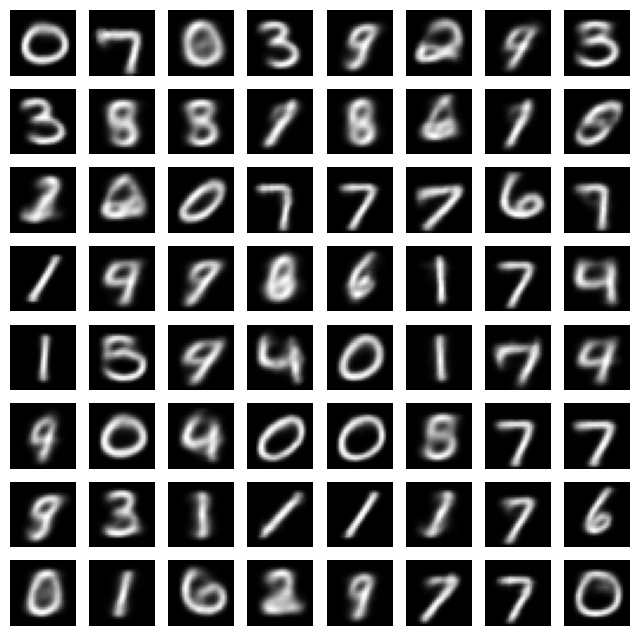

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [ ]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:10].cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)

In [ ]:
from collections import defaultdict

data_centroids_dict = defaultdict(list)

for mu, y in zip(z_all, pred_y_all):
    data_centroids_dict[y].append(mu)

cluster_centroids_from_data = []
for numb in range(0,10):
    cluster_centroids_from_data.append(np.mean(data_centroids_dict[numb], axis=0))

cluster_centroids_from_data

f:\Python38\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
f:\Python38\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[array([-0.8,  0.1, -0.7,  0. , -0.1,  0. ,  0.1,  0.1, -0. ,  0. , -0. ,
         0.1], dtype=float32),
 array([ 0.8,  0.1,  0.4,  0.1,  0. , -0.1, -0.4, -0. ,  0. ,  0.1,  0. ,
         0. ], dtype=float32),
 array([-0.3, -0. ,  0.2,  0. , -0.1, -0. , -0.6, -0.1,  0.1, -0. , -0.1,
        -0.1], dtype=float32),
 array([-0.3, -0.1,  0.4,  0. ,  0.1,  0.1, -0.3,  0. ,  0. ,  0. , -0. ,
         0.6], dtype=float32),
 array([ 0.1,  0. ,  0. , -0. ,  0.1, -0. ,  0.6,  0. , -0. , -0. , -0.1,
        -0.2], dtype=float32),
 array([-0.1,  0.1, -0.2, -0.1,  0.1,  0. ,  0. , -0.1, -0.1,  0. ,  0.1,
         0.3], dtype=float32),
 array([-0.5, -0. ,  0.1, -0.1,  0. , -0. , -0.1,  0. , -0.1, -0. ,  0.1,
        -0.8], dtype=float32),
 array([ 0.6, -0.1, -0.1,  0. , -0.1,  0. ,  0.6, -0.1,  0. , -0. ,  0. ,
         0.1], dtype=float32),
 nan,
 nan]

In [ ]:
np.sum(y_all==pred_y_all)/len(y_all)

0.8054

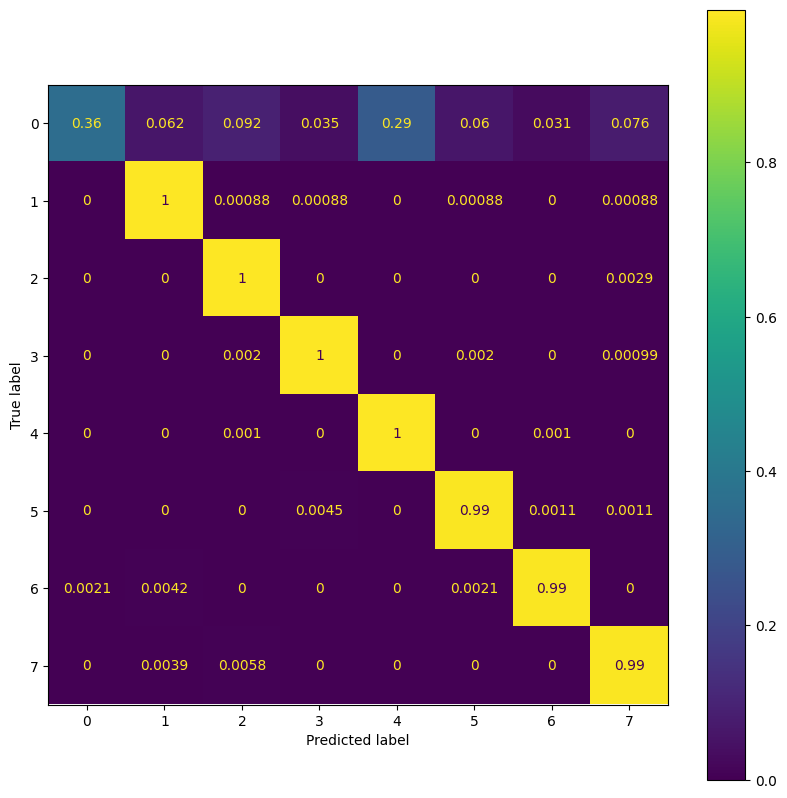

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (10, 10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

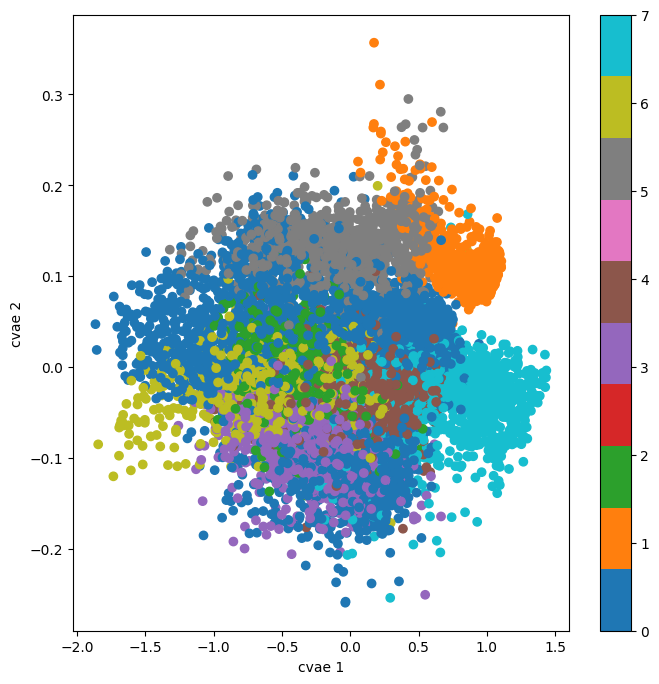

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")

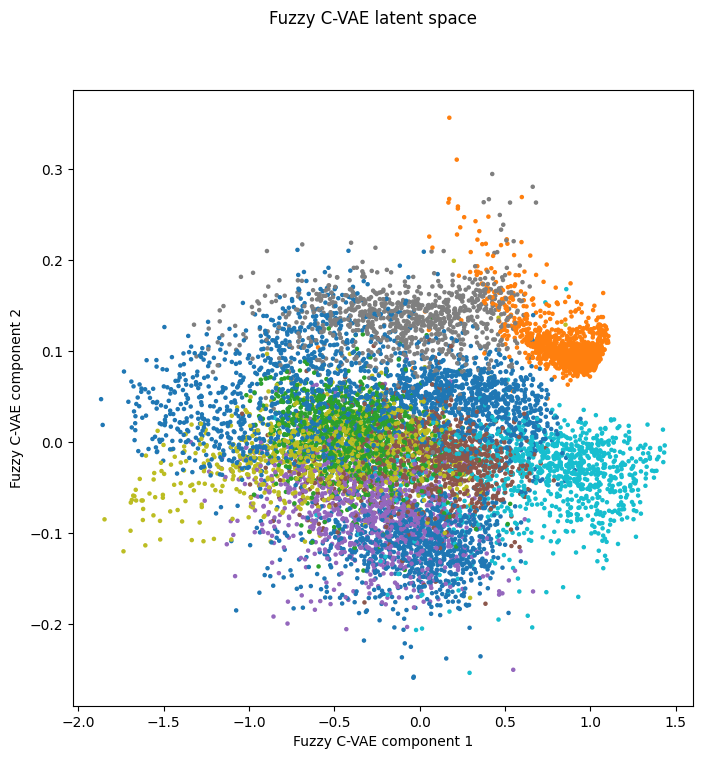

In [ ]:
mask = "Fuzzy C-VAE"
if not is_fuzzy_loss_active:
    mask = "VAE"
import matplotlib.colors
# figure, axis = plt.subplots(2, 3, figsize=(17, 10)) 
# axis[0][0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
# axis[0][0].set_title("")
# axis[0][0].set_xlabel(f"{mask} component 1")
# axis[0][0].set_ylabel(f"{mask} component 2")


plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=5)
plt.xlabel(f"{mask} component 1")
plt.ylabel(f"{mask} component 2")
plt.suptitle(f'{mask} latent space')
if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig2b-fcvae-all-features.eps', format='eps')
else:
    plt.savefig('papers/iiti24/fig2a-vae-all-features.eps', format='eps')
plt.show()


In [ ]:
domains_scatter_points = []
for x in np.linspace(-1.9, 2.0, 200):
    for y in np.linspace(-1.2, 2, 200):
        fuzzy_inference = model.fuzzy.forward(torch.FloatTensor([[x,y]]).to(device)).cpu().detach().numpy()
        fuzzy_class =np.argmax(fuzzy_inference[0,0:10])
        domains_scatter_points.append([x,y,fuzzy_class])

domains_scatter_points = np.array(domains_scatter_points)

RuntimeError: mat1 dim 1 must match mat2 dim 0

TypeError: list indices must be integers or slices, not tuple

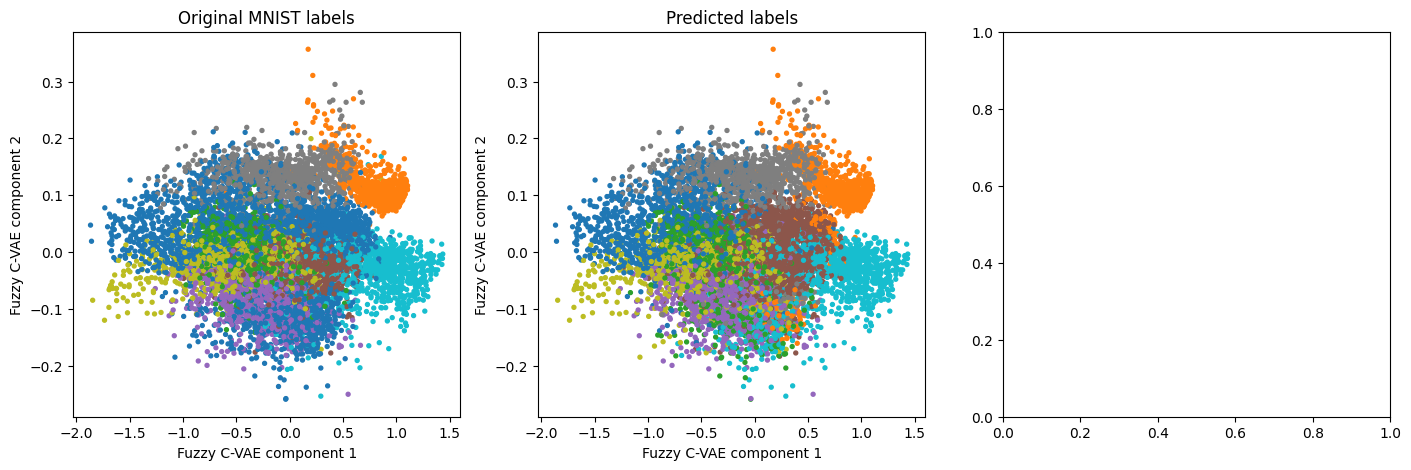

In [ ]:
import matplotlib.colors
figure, axis = plt.subplots(1, 3, figsize=(17, 5)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
axis[0].set_title("Original MNIST labels")
axis[0].set_xlabel(f"{mask} component 1")
axis[0].set_ylabel(f"{mask} component 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10', s=8)
axis[1].set_title("Predicted labels") 
axis[1].set_xlabel(f"{mask} component 1")
axis[1].set_ylabel(f"{mask} component 2")
tmm_cmap = matplotlib.colors.ListedColormap(['red', 'green'])

sc3 = axis[2].scatter(domains_scatter_points[:, 0], domains_scatter_points[:, 1], c = domains_scatter_points[:, 2], s=3, cmap='tab10')
axis[2].set_title("Predicted outline classes") 
axis[2].set_xlabel(f"{mask} component 1")
axis[2].set_ylabel(f"{mask} component 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
figure.colorbar(sc3)

if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig3-fcvae-classification.eps', format="eps")
plt.show()

## Data generation

torch.Size([10, 12])


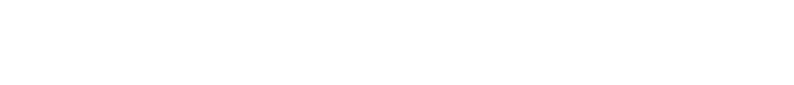

In [ ]:
n = 10
path_from_4_to_9 = np.linspace(cluster_centroids_from_data[7], cluster_centroids_from_data[9], n)
path_from_4_to_9 = [torch.FloatTensor(a) for a in path_from_4_to_9]

z = torch.stack(path_from_4_to_9, dim=0).to(device)
print(z.shape)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('papers/iiti24/fig4-sample-generation.eps', format="eps")
plt.show()


tensor([[ 0.1564,  1.1179, -0.0112,  0.0017, -0.0406,  0.0189, -0.0028,  0.0152,
          0.0215, -0.0127,  0.4934, -0.5733]], device='cuda:0',
       grad_fn=<SplitBackward>)
[[0.  0.1 0.9 0.  0.  0.  0.  0.  0.  0.  0.5 0.3]]


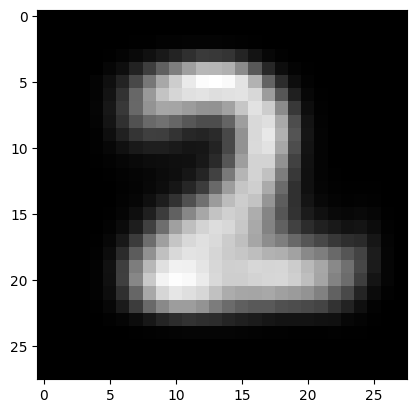

In [ ]:

mu, std, z, fz = model.half_pass(test_data[1][0].reshape((1,1,28,28)).to(device))

# mu[0][0] = -2.8242958
# mu[0][1] = -0.39727297

print(mu)
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
print(fz.cpu().detach().numpy())
samples = model.decoder_pass(mu)
#samples = torch.sigmoid(samples)
plt.imshow(samples[0].view(28, 28).cpu().detach().numpy(), cmap='gray')
    

## Anomaly detection

In [ ]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [ ]:
import pandas as pd

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

C:\Users\Юрий\AppData\Local\Temp\ipykernel_13368\2301690307.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]


103600

In [ ]:
emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))
emnist_mapping

{1: 'Aa',
 2: 'Bb',
 3: 'Cc',
 4: 'Dd',
 5: 'Ee',
 6: 'Ff',
 7: 'Gg',
 8: 'Hh',
 9: 'Ii',
 10: 'Jj',
 11: 'Kk',
 12: 'Ll',
 13: 'Mm',
 14: 'Nn',
 15: 'Oo',
 16: 'Pp',
 17: 'Qq',
 18: 'Rr',
 19: 'Ss',
 20: 'Tt',
 21: 'Uu',
 22: 'Vv',
 23: 'Ww',
 24: 'Xx',
 25: 'Yy',
 26: 'Zz'}

In [ ]:
model.eval()

anomaly_rates = defaultdict(list)

with torch.no_grad():
    for data, label in zip(emnist_x, emnist_y):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, flabels= model.forward(data)
        
        max_firing = flabels[0][0:10].max().cpu().numpy()
        anomaly_rates[emnist_mapping[label]].append(max_firing)

anomaly_rates

defaultdict(list,
            {'Aa': [array(0.4, dtype=float32),
              array(0.1, dtype=float32),
              array(0.4, dtype=float32),
              array(0.2, dtype=float32),
              array(0.4, dtype=float32),
              array(0.4, dtype=float32),
              array(0.3, dtype=float32),
              array(0.4, dtype=float32),
              array(0.3, dtype=float32),
              array(0.7, dtype=float32),
              array(0.3, dtype=float32),
              array(0.4, dtype=float32),
              array(0.9, dtype=float32),
              array(0.3, dtype=float32),
              array(0.2, dtype=float32),
              array(0.2, dtype=float32),
              array(0.5, dtype=float32),
              array(0.3, dtype=float32),
              array(0.3, dtype=float32),
              array(0.2, dtype=float32),
              array(0.3, dtype=float32),
              array(0.3, dtype=float32),
              array(0.5, dtype=float32),
              array(0.4, dtype=fl

In [ ]:
anomaly_stats = []

for k in anomaly_rates.keys():
    anomaly_stats.append(
        {
            'Letters': k,
            'Mean': np.mean(anomaly_rates[k]),
            'Std': np.std(anomaly_rates[k]),
            'Max': np.max(anomaly_rates[k]),
        }
    )
pd.DataFrame(anomaly_stats)

,Letters,Mean,Std,Max
0,Aa,0.369372,0.178703,0.995921
1,Bb,0.453600,0.212417,0.999475
2,Cc,0.507577,0.217195,0.997907
3,Dd,0.489630,0.233857,0.998880
4,Ee,0.470377,0.176683,0.996941
5,Ff,0.487396,0.224420,0.996130
6,Gg,0.430927,0.183936,0.999135
7,Hh,0.414801,0.191800,0.996490
8,Ii,0.389152,0.186646,0.995183
9,Jj,0.457107,0.188157,0.996806


In [ ]:
pd.DataFrame(anomaly_stats).to_latex()

'\\begin{tabular}{llrrr}\n\\toprule\n & Letters & Mean & Std & Max \\\\\n\\midrule\n0 & Aa & 0.369372 & 0.178703 & 0.995921 \\\\\n1 & Bb & 0.453600 & 0.212417 & 0.999475 \\\\\n2 & Cc & 0.507577 & 0.217195 & 0.997907 \\\\\n3 & Dd & 0.489630 & 0.233857 & 0.998880 \\\\\n4 & Ee & 0.470377 & 0.176683 & 0.996941 \\\\\n5 & Ff & 0.487396 & 0.224420 & 0.996130 \\\\\n6 & Gg & 0.430927 & 0.183936 & 0.999135 \\\\\n7 & Hh & 0.414801 & 0.191800 & 0.996490 \\\\\n8 & Ii & 0.389152 & 0.186646 & 0.995183 \\\\\n9 & Jj & 0.457107 & 0.188157 & 0.996806 \\\\\n10 & Kk & 0.415668 & 0.181872 & 0.994226 \\\\\n11 & Ll & 0.439903 & 0.221915 & 0.998998 \\\\\n12 & Mm & 0.584357 & 0.230310 & 0.997755 \\\\\n13 & Nn & 0.545133 & 0.260700 & 0.998111 \\\\\n14 & Oo & 0.900672 & 0.115964 & 0.999417 \\\\\n15 & Pp & 0.636329 & 0.250816 & 0.996725 \\\\\n16 & Qq & 0.417103 & 0.170006 & 0.997010 \\\\\n17 & Rr & 0.506681 & 0.214104 & 0.997279 \\\\\n18 & Ss & 0.472433 & 0.213256 & 0.996587 \\\\\n19 & Ww & 0.831695 & 0.187114 & 0

tensor([0.0093, 0.0792, 0.0105, 0.0488, 0.0191, 0.0431, 0.0262, 0.2644, 0.2774,
        0.1546, 0.3794, 0.4195], device='cuda:0')
tensor(0.2774, device='cuda:0')


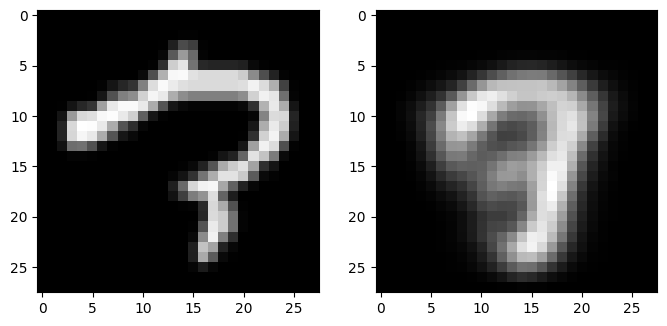

In [ ]:
model.eval()

with torch.no_grad():
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    data = emnist_x[1000]
    data = data.view((-1,1,28,28)).to(device)
    mu, x_recon, flabels= model.forward(data)
    print(flabels[0])
    print(flabels[0][0:10].max())
    ax[0].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(x_recon.view(28, 28).cpu().detach().numpy(), cmap='gray')